### Imports

In [1]:
from sklearn.model_selection import train_test_split
from random import shuffle
import skimage.transform as transform
import csv
import cv2
import numpy as np
import sklearn
import math
import pandas as pd
import os
import glob

# Keras
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda,  Dropout,Cropping2D, Convolution2D
from keras.optimizers import Adam
from data import *

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
data = pd.read_csv('./data/driving_log.csv')
data.mean()

# Split traning data
train_samples, validation_samples = train_test_split(data, test_size=0.2)

### Load data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f076b049a58>]], dtype=object)

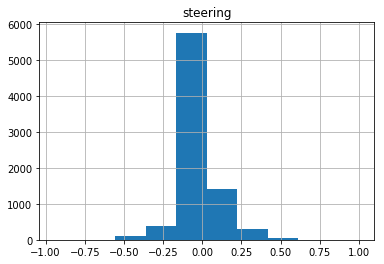

In [5]:
data.hist(column='steering')

In [6]:
df = pd.read_csv('data/driving_log.csv')

balanced = pd.DataFrame()   # Balanced dataset
bins = 1000                 # N of bins
bin_n = 200                 # N of examples to include in each bin (at most)

start = 0
for end in np.linspace(0, 1, num=bins):  
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if range_n == 0:
        continue
    balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
balanced.to_csv('data/driving_log_balanced.csv', index=False)

(array([   5,    6,   40,  225,  661, 1478, 1072,  289,   48,   12]),
 array([-0.9426954 , -0.77527015, -0.6078449 , -0.44041965, -0.2729944 ,
        -0.10556915,  0.0618561 ,  0.22928135,  0.3967066 ,  0.56413185,
         0.7315571 ]))

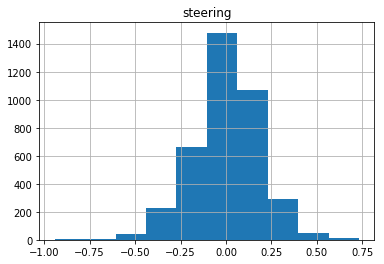

In [7]:
df = pd.read_csv('data/driving_log_balanced.csv')
df.hist(column='steering')

x = df.as_matrix(columns=['steering'])
np.histogram(x)

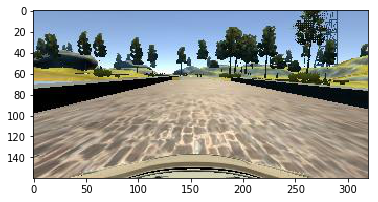

In [8]:
filename = "./data/IMG/"+ data.iloc[0]['center'].split("/")[-1]
image    = plt.imread(filename)
plt.imshow(image)

### Data augmentation

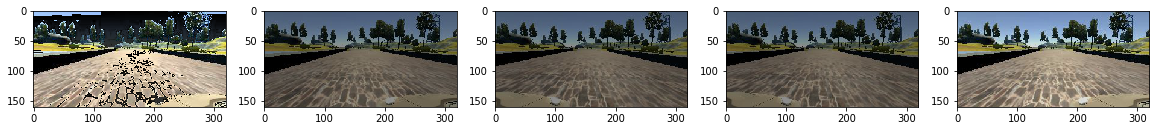

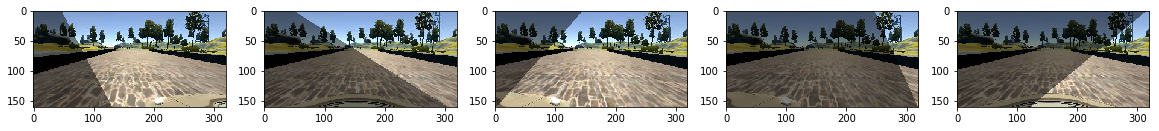

In [28]:
import random

def random_brightness(image):
    # Randomly select a percent change
    change_pct = random.uniform(0.4, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_brightness

def random_shadow(image):
    h, w = image.shape[0], image.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = - k * x1
    for i in range(h):
        c = int((i - b) / k)
        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
    return image

def trans_image(image, steer):
    trans_range = 100
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * 2 * .2
    tr_y = 0
    M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return image_tr, steer_ang

size = 5
plt.figure(figsize=(20,20))
for i in range(size):
    image, angle = select_image(data,0)
    plt.subplot(1,size,i+1)
    plt.imshow(random_brightness(image))
    
plt.figure(figsize=(20,20))
for i in range(size):
    image, angle = select_image(data,0)
    plt.subplot(1,size, i+1)
    plt.imshow(random_shadow(image))

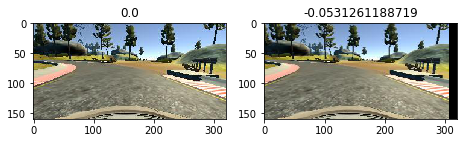

In [29]:
plt.figure(figsize=(20,20))
for i in range(1):
    image, angle = select_image(data,5)
    plt.subplot(1,size, i+1)
    plt.title(str(angle))
    plt.imshow(image)
    
    image, angle = trans_image(image, angle)
    plt.subplot(1,size, i+2)
    plt.title(str(angle))
    plt.imshow(image)

### Generator

Create generator to preprocess data

#### Create traning anf validation


In [60]:
#train_generator = samples_generator(train_samples, batch_size=32)
#validation_generator = samples_generator(validation_samples, batch_size=32)

train_generator      = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

### Build model

In [61]:
learning_rate = 0.0001 # (good result)


opt = Adam(lr=learning_rate)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((55,22), (0,0))))
model.add(Convolution2D(24, 5,5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(36, 5,5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(48, 5,5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(64, 3,3, subsample=(1, 1), activation="relu"))
model.add(Convolution2D(64, 3,3, subsample=(1, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(1164,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100,activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(50,activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mse", optimizer=opt)
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 160, 320, 3)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
cropping2d_3 (Cropping2D)        (None, 83, 320, 3)    0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 40, 158, 24)   1824        cropping2d_3[0][0]               
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 18, 77, 36)    21636       convolution2d_11[0][0]           
___________________________________________________________________________________________

### Train

In [ ]:
batch_size  = 128
epochs      = 5
samples_per_epoch  = math.ceil((len(train_samples)*8)/batch_size) * batch_size
nb_val_samples     = math.ceil((len(validation_samples)*8) / batch_size) * batch_size

history = model.fit_generator(
    train_generator, 
    samples_per_epoch=samples_per_epoch, 
    validation_data=validation_generator,
    nb_val_samples=nb_val_samples, 
    nb_epoch=epochs,
    verbose=1).history

Epoch 1/5
51424/51456 [============================>.] - ETA: 0s - loss: 0.0260

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


51552/51456 [==============================] - 204s - loss: 0.0260 - val_loss: 0.0246
Epoch 2/5
51552/51456 [==============================] - 199s - loss: 0.0200 - val_loss: 0.0212
Epoch 3/5
14136/51456 [=======>......................] - ETA: 108s - loss: 0.0182

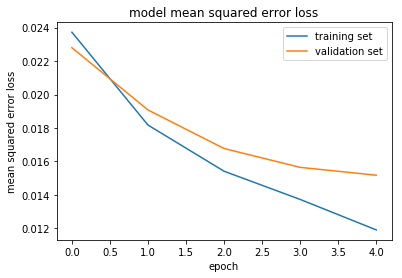

In [52]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save("model.h5")


In [53]:
X,y = next(validation_generator)
            
prediction = model.predict(X)  

array([ 0.        ,  0.5318362 ,  0.33824026,  0.1861508 ,  0.25      ,
       -0.25      , -0.25      , -0.0376218 ,  0.25      ,  0.        ,
       -0.1047936 ,  0.25      ,  0.25      ,  0.3952064 ,  0.4839935 ,
       -0.25      , -0.25      ,  0.        ,  0.1212604 ,  0.        ,
       -0.1262177 ,  0.16175974,  0.25      ,  0.        , -0.24720896,
       -0.4170138 ,  0.25      , -0.135712  ,  0.7232068 ,  0.        ,
       -0.30975719,  0.25      ])

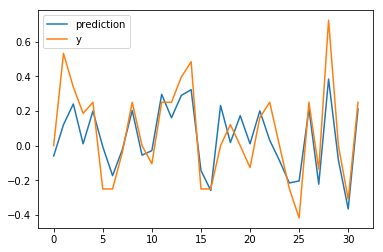

In [54]:
plt.plot([i for i in range(0,32)], prediction, label='prediction')
plt.plot([i for i in range(0,32)], y, label="y")
plt.legend()

y

[[ 0.14967452]
 [-0.01946236]
 [ 0.0747108 ]]


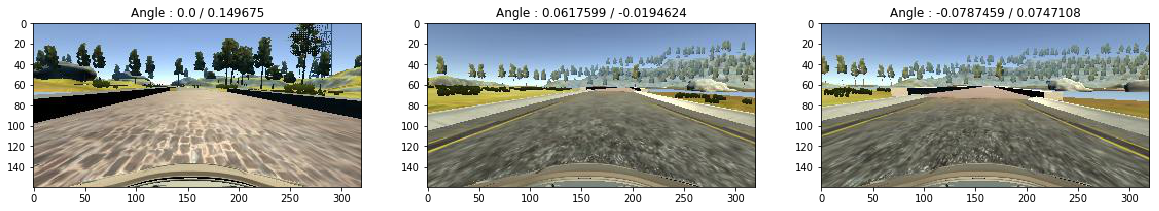

In [55]:
data = pd.read_csv("./data/driving_log.csv")


center_data = data[data.steering == 0].iloc[0]
left_data   = data[data.steering > 0].iloc[0]
right_data  = data[data.steering < 0].iloc[0]

center = plt.imread("./data/" + center_data['center'])
left   = plt.imread("./data/" + left_data['center']) 
right  = plt.imread("./data/" + right_data['center'])

images = [center,left,right]
angles = [center_data['steering'], left_data['steering'], right_data['steering']]

p = model.predict(np.array(images))
print(p)

plt.figure(1,figsize=(20,20))
for idx, image in enumerate(images):
    plt.subplot(1,3,idx+1)
    plt.title('Angle : ' + str(angles[idx]) + " / " + str(p[idx][0]))
    plt.imshow(image)
plt.show()

(160, 320, 3)


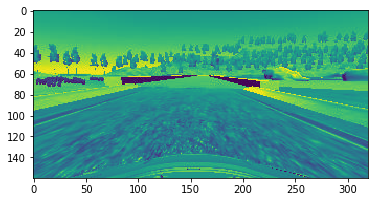

In [56]:
image = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
print(image.shape)
plt.imshow(image[:,:,0])

In [57]:
x = data[data.steering < 0]
path  = x.iloc[0]['center']
angle = x.iloc[0]['steering']
print(path, angle)
#data.columns



IMG/center_2016_12_01_13_32_46_185.jpg -0.0787459


In [58]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def show_activations(activations_map,plt_num=1):
    activations  = activations_map[0] # We should have only one sample
    nactivations = activations.shape[2]
    plt.figure(plt_num,figsize=(15,15))
    for idx in range(nactivations):
        plt.subplot(8,6, idx+1)
        plt.axis('off')
        plt.imshow(activations[:,:,idx], interpolation='None', cmap='jet')

        

[[-0.02561968]
 [ 0.54972714]
 [-0.46027702]
 [ 0.48561433]
 [-0.3925283 ]
 [-0.01918894]
 [ 0.73967522]
 [-0.07763807]
 [ 0.1582323 ]
 [ 0.07562097]]
(40, 158)
[[ 0.11638665  0.11277835  0.16392581 ...,  0.0477088   0.07562901
   0.10179336]
 [ 0.00848155  0.01951414  0.03020161 ...,  0.09935041  0.09656596
   0.11362015]
 [ 0.05209423  0.06343788  0.0610064  ...,  0.00150225  0.          0.        ]
 ..., 
 [ 0.09174587  0.1432018   0.11146371 ...,  0.          0.02112398
   0.09427689]
 [ 0.05817939  0.01205135  0.         ...,  0.00247013  0.          0.        ]
 [ 0.00951557  0.          0.         ...,  0.          0.03225249
   0.02327093]]


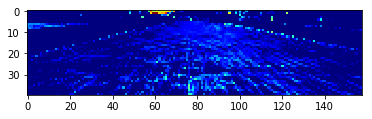

In [59]:
from keras import backend as K



layer = model.layers[2]

image, angle= select_image(data,1)
image   = np.array([center])

weights = model.get_weights()
print(weights[18])

# funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
func = K.function([model.layers[0].input], [model.layers[2].output])
activation = func([image])
activation_map = activation[0]
#plt.imshow(activation[0][0])
print(activation_map[0][:,:,0].shape)
activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
print(activation_map[0][:,:,0])
#deprocess_image(activation_map[0][:,:,2])
plt.imshow(activation_map[0][:,:,2],  cmap='jet')
#plt.figure()
#plt.imshow(activations, interpolation='None', cmap='jet')


In [242]:
from read_activations import *

In [22]:
activations = get_activations(model, np.array([right]), print_shape_only=True)
print(activations[13])
show_activations(activations[2])
plt.suptitle('Convolution Layer 1')
show_activations(activations[3],2)
plt.suptitle('Convolution Layer 2')
show_activations(activations[4],3)
plt.suptitle('Convolution Layer 3')

#display_activations(activations)

NameError: name 'get_activations' is not defined

In [7]:
for i in range(2000):
    x,y = next(train_generator)
    if len(y) != 32:
        print(len(y))

28
28


KeyboardInterrupt: 

In [9]:
idx = np.random.permutation(data.count()[0])
data.iloc[idx]

len(idx)

8036